In [12]:
from systems.long_multirotor import LongTrajEnv

import notebook_setup
from typing import Union, Iterable, List
from copy import deepcopy
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from tqdm.autonotebook import tqdm, trange
import optuna

from rl import learn_rl, transform_rl_policy, evaluate_rl, PPO, load_agent
from multirotor.simulation import Multirotor
from multirotor.helpers import DataLog
from multirotor.visualize import plot_datalog
from multirotor.controller import Controller
from multirotor.trajectories import Trajectory, GuidedTrajectory
from multirotor.controller.scurves import SCurveController
from systems.multirotor import MultirotorTrajEnv, VP
from multirotor.controller import (
    AltController, AltRateController,
    PosController, AttController,
    VelController, RateController,
    Controller
)
from scripts.opt_pidcontroller import (
    get_controller, make_disturbance_fn,
    apply_params as apply_params_pid, get_study as get_study_pid
)
from scripts.opt_multirotorenv import apply_params, get_study, get_established_controller

In [15]:
def get_env(params={}, scurve=False, **kwargs):  
    kw = dict(
        safety_radius=10,
        vp=VP,get_controller_fn=lambda m: get_established_controller(m),
        steps_u=50,
        scaling_factor=0.5,
        seed=0)
    return MultirotorTrajEnv(**kw)

In [3]:
env = LongTrajEnv(
    waypoints=np.array([[0,0,0], [20,0,0], [40,0,0], [60,0,0]]),
    base_env = get_env()
)
done = False
env.reset()
log = DataLog(env.base_env.vehicle, env.base_env.ctrl,
                  other_vars=('reward',))
while not done:
    state, reward, done, _ = env.step([0,0,0])
    log.log(reward=reward)
# plotting logic

/home/courseac/projects/transfer_similarity/src/systems/long_multirotor.py:21: RuntimeWarning: invalid value encountered in divide
  self.base_env._des_unit_vec = waypt_vec / np.linalg.norm(waypt_vec) # do I need to norm this?


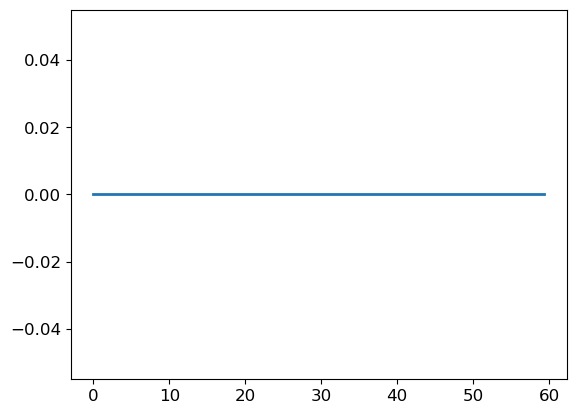

In [4]:
plt.plot(log.x, log.y)

In [5]:
square_np = np.array([[100,0,0], [100,100,0], [0,100,0], [0,0,0]])
big_square = Trajectory(None, points=square_np, resolution=20)

In [6]:
square_wpts = big_square.generate_trajectory(curr_pos=np.array([0,0,0]))

In [7]:
env = LongTrajEnv(
    waypoints = square_wpts,
    base_env = get_env()
)
done = False
env.reset()
log = DataLog(env.base_env.vehicle, env.base_env.ctrl,
                  other_vars=('reward',))
while not done:
    state, reward, done, _ = env.step([0,0,0])
    log.log(reward=reward)
# plotting logic

/home/courseac/projects/transfer_similarity/src/systems/long_multirotor.py:21: RuntimeWarning: invalid value encountered in divide
  self.base_env._des_unit_vec = waypt_vec / np.linalg.norm(waypt_vec) # do I need to norm this?


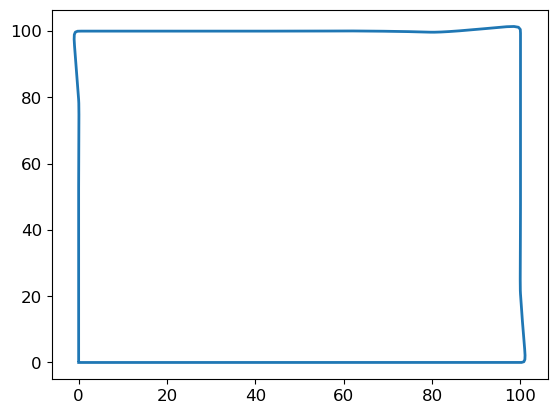

In [8]:
plt.plot(log.x, log.y)

In [9]:
def get_tte(initial_pos: tuple, waypoints: np.ndarray, x: np.ndarray, y:np.ndarray, z:np.ndarray) -> np.ndarray:
        """
        Calculates the trajectory tracking error. 
        The distance between the current point and the vector between previous and next wp. Uses ||v1 x v2|| / ||v1||.

        Parameters
        ----------
        initial_pos : tuple  
            the initial position of the UAV.
        waypoints : np.ndarray 
            the reference positions at each point in time.
        x : np.ndarray 
            the x positions of the UAV.
        y : np.ndarray 
            the y positions of the UAV.
        z : np.ndarray
            the z positions of the UAV.

        Returns
        -------
        np.ndarray 
            the trajectory tracking error at each point in time.
        """
        ttes = []
        prev = initial_pos
        for i, waypoint in enumerate(waypoints):
            if i > 0 and not np.array_equal(waypoints[i-1], waypoints[i]):
                prev = waypoints[i-1]

            v1 = waypoint - prev
            v2 = np.array([x[i],y[i],z[i]]) - prev
            tte = np.linalg.norm(np.cross(v1, v2)) / np.linalg.norm(v1)
            ttes.append(tte)
                
        return np.array(ttes)

In [ ]:
def completed_mission(waypoints: np.ndarray, x: np.ndarray, y: np.ndarray, z: np.ndarray, radius: float = 2.):
        for waypoint in waypoints:
            reached_waypoint = False

            for position in zip(x,y,z):
                dist = np.linalg.norm(waypoint - position)

                if dist <= radius:
                    reached_waypoint = True
                    break

            if not reached_waypoint:
                return False
            
        return True

In [10]:
np.sum(get_tte(np.array([0,0,0]), log.states[:,12:], log.x, log.y, log.z))

38.41703273408348

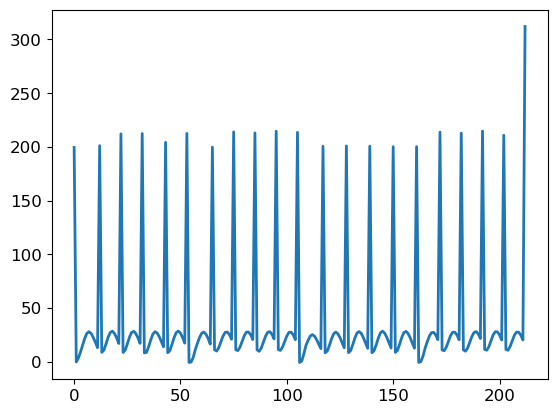

In [11]:
plt.plot(log.reward)